构建一个逻辑回归模型预测一个学生是否会被大学录取。根据申请人两次考试的成绩来判断他们被录取的可能性。你有可以用作逻辑回归训练集的以前申请者的历史数据。每个训练样本都包含历史申请人两次考试的成绩和最终的录取结果。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1.1 可视化数据

In [2]:
data = pd.read_csv('data/ex2data1.txt', names = ['exam1', 'exam2', 'admitted'])
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


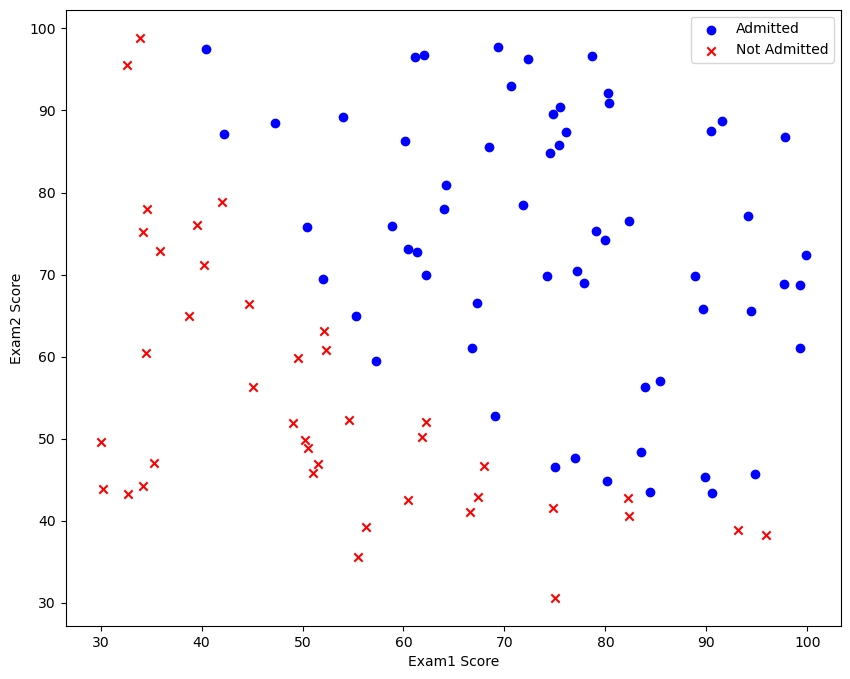

In [3]:
positive = data[data['admitted'] == 1]
negative = data[data['admitted'] == 0]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(positive['exam1'], positive['exam2'], c='b', marker='o', label='Admitted')
ax.scatter(negative['exam1'], negative['exam2'], c='r', marker='x', label='Not Admitted')

ax.legend()
ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
plt.show()

### 1.2 实现

#### 1.2.1 Sigmoid函数

$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$

In [4]:
def sigmoid(z):
    return 1 / (1+ np.exp(-z))

#### 1.2.2 代价函数和梯度

逻辑回归的代价函数：

$J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {h_\theta}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{h_\theta}\left( {{x}^{(i)}} \right) \right)]}$

$h_\theta \left( x \right)=g\left(\theta^{T}X \right)$

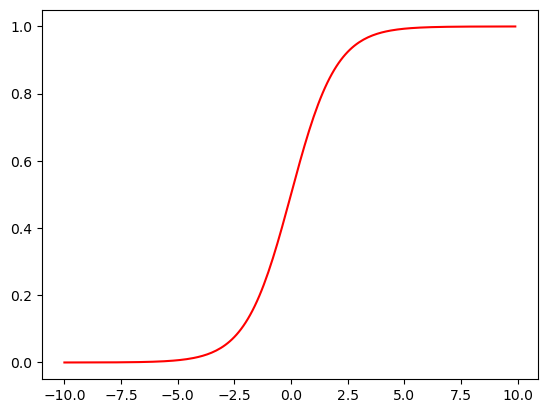

In [5]:
x1 = np.arange(-10, 10, 0.1)
plt.plot(x1, sigmoid(x1), c='r')
plt.show()

In [16]:
def loss_function(theta, X, y):
    first = (-y) * np.log(sigmoid(X@theta))
    second = (1 - y) * np.log(1 - sigmoid(X@theta))
    return np.mean(first - second)

In [7]:
if 'ones' not in data.columns:
    data.insert(0, 'ones', 1)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

theta = np.zeros(X.shape[1])

In [8]:
X.shape, y.shape, theta.shape

((100, 3), (100,), (3,))

In [9]:
loss_function(X, y, theta)

0.6931471805599453

#### 1.2.3梯度函数

转化为向量化计算：$\frac{1}{m}X^T(Sigmoid(X\theta)-y)$

In [17]:
def gradient(theta, X, y):
    return (X.T@(sigmoid(X@theta) - y)) / len(X)

In [13]:
gradient(X, y, theta)

array([ -0.1       , -12.00921659, -11.26284221])

#### 1.2.4 学习$\theta$参数

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算梯度。在练习中，一个称为“fminunc”的Octave函数是用来优化函数来计算成本和梯度参数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

In [18]:
import scipy.optimize as opt

result = opt.fmin_tnc(func=loss_function, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131865,   0.20623159,   0.20147149]), 36, 0)

注意$X_0$是第一个传入的参数，args是额外传入的参数，所以在定义损失函数和梯度函数的时候，需要把theta参数作为第一个传入的参数，否则会出现矩阵相乘时行列不相等的报错。

In [19]:
loss_function(result[0], X, y)

0.2034977015894745

### 1.3 评估逻辑回归

我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，我们可以使用这个函数来给我们的分类器的训练精度打分。

In [20]:
def predict(theta, X):
    predictions = sigmoid(X@theta)
    return [1 if x>=0.5 else 0 for x in predictions]

In [21]:
final_theta = result[0]
predictions = predict(final_theta, X)
correct = [1 if a==b else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(correct) / len(X)
accuracy

0.89

### 1.4 决策边界

$X \times \theta = 0$ this is the line

e.x. $\theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 = 0$


In [30]:
x1 = np.arange(130, step = 0.1)
x2 = -(final_theta[0] + x1*final_theta[1]) / final_theta[2]

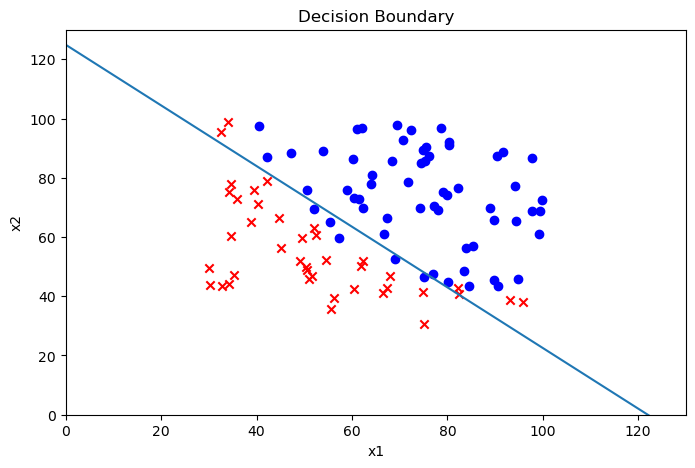

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(positive['exam1'], positive['exam2'], c='b', label='Admitted')
ax.scatter(negative['exam1'], negative['exam2'], c='r', marker='x',label='Not Admitted')
ax.plot(x1, x2)
ax.set_xlim(0, 130)
ax.set_ylim(0, 130)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Decision Boundary')
plt.show()

## 2 正则化逻辑回归

正则化有助于减少过拟合，提高模型的泛化能力。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

### 2.1 可视化

In [35]:
data2 = pd.read_csv('data/ex2data2.txt', names=['Test1', 'Test2', 'Accepted'])
data2.head()

,Test1,Test2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


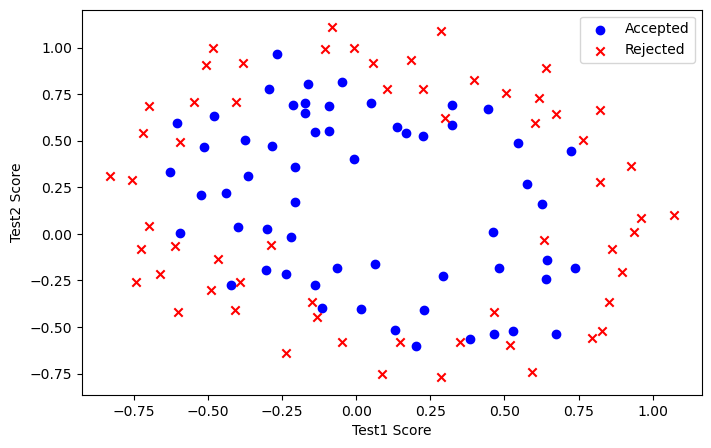

In [36]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(positive['Test1'], positive['Test2'], c='b', marker='o', label='Accepted')
ax.scatter(negative['Test1'], negative['Test2'], c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test1 Score')
ax.set_ylabel('Test2 Score')
plt.show()

.isin([1]) 是一个 pandas DataFrame 或 Series 对象上的方法，用于检查每个元素是否包含在给定的列表中。

注意到其中的正负两类数据并没有线性的决策界限。因此直接用logistic回归在这个数据集上并不能表现良好，因为它只能用来寻找一个线性的决策边界。

### 2.2 特征映射

更好地拟合数据的一种方法是从每个数据点创建更多的特性。我们将把特征映射到x1和x2的所有多项式项直到特征的6次方。

这个映射的结果是，我们的两个特征向量(两个QA测试的分数)被转换成一个28维的向量。在这个高维特征向量上训练逻辑回归分类器将具有更复杂的决策边界，并且在二维图中呈现非线性。虽然特征映射允许我们构建一个更具表现力的分类器，但它也更容易过度拟合。